# Compute Compositions
Compute the composition of each molecule so that we can identify constitutional isomers. You will need to have downloaded the QM9 dataset in data/raw to run this script.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

## Load in the QM9 dataset
We are going to use QM9 as our standard dataset for this analysis.

In [2]:
data = pd.read_json('data/raw/g4mp2_data.json.gz', lines=True)
print(f'Read in a dataset of {len(data)} molecules')

Read in a dataset of 130258 molecules


## Remove any duplicates

In [3]:
data.sort_values('g4mp2_0k', inplace=True, ascending=True) # sort lowest to highest energy
data.drop_duplicates('inchi_0', inplace=True, keep='first') # keep the most stable duplicate
print(f'Trimmed down to {len(data)} unique molecules')

Trimmed down to 126405 unique molecules


## Compute the Chemical Composition
Easily done, as this is the second field of the InChI string

In [4]:
def get_composition(inchi: str):
    """Get the chemical composition from an InChI string
    
    Args:
        inchi: InChI string
    Returns:
        Chemical formula
    """
    return inchi.split("/")[1]

In [5]:
data['formula'] = data.inchi_1.apply(get_composition)

## Count how many stereoisomers we have
Just to get an idea of how many we'll be able to assess

In [6]:
%%time
formula_counts = data.groupby('formula')['formula'].count()
print(f'Found {len(formula_counts)} unique formula out of {len(data)} molecules. Average of {len(data)/len(formula_counts):.1f} per formula')

Found 697 unique formula out of 126405 molecules. Average of 181.4 per formula
CPU times: user 39.1 ms, sys: 6.89 ms, total: 46 ms
Wall time: 42.3 ms


## Print out counts for the 10 formulas with the most isomers

In [7]:
formula_counts.sort_values(ascending=False, inplace=True)
formula_counts.head(10)

formula
C7H10O2    6080
C7H11NO    5844
C6H9NO2    5610
C7H9NO     5172
C8H12O     4898
C7H12O2    4608
C6H7NO2    3817
C6H8N2O    3324
C8H14O     3145
C8H10O     3145
Name: formula, dtype: int64

## Compute $E_{min}$ for each molecule
Get the energy above the minimum energy isomer

In [8]:
data['Emin'] = 0 # initialize values

In [9]:
for gid, group in data.groupby('formula'):
    data.loc[group.index, 'Emin'] = group['g4mp2_0k'] - group['g4mp2_0k'].min() # calculate the difference between an isomer's energy and the lowest energy among all isomers
    data.loc[group.index,'isomers_in_formula'] = len(group)

## Visualize some energy variations
How different are the energies of these isomers

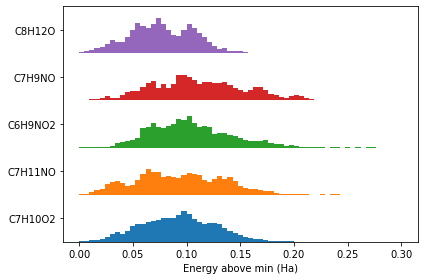

In [10]:
fig, ax = plt.subplots()

bins = np.linspace(0, 0.3, 64)
spacing = 20
for i, formula in enumerate(formula_counts[:5].index):
    ax.hist(data.query(f'formula=="{formula}"')['Emin'], bins=bins, density=True, bottom=spacing*i)
    
ax.set_yticks(np.arange(5) * spacing + spacing / 2)
ax.set_yticklabels(formula_counts[:5].index)

ax.set_xlabel('Energy above min (Ha)')

fig.tight_layout()

We can see a pretty large energy difference between some isomers. A typical energy difference of 0.1 Ha for a 20 atom molecule is about 0.01 Ha/atom, or about 136 meV/atom - smaller than the [thermodynamic scale of instability of inorganic materials](https://www.science.org/doi/10.1126/sciadv.1600225).

## Save the data
We'll want that list of compositional isomers and the dataset with the energies above minimum

In [11]:
cleaned_data = Path('./data/clean/')
cleaned_data.mkdir(exist_ok=True)
data.to_csv(cleaned_data / 'qm9.csv', index=False)
formula_counts.rename("counts").to_csv('formula_counts.csv')